In [1]:
%reload_ext autoreload
%autoreload 2

from alpharaw.mzml import MzMLReader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from alphabase.spectral_library.base import SpecLibBase

In [2]:
base_folder = "C:/Code/Eubic2025/alphadia-validate/"
data_folder = f'{base_folder}/data'
output_folder = f'{base_folder}/output'

### 1. Set up data
First we will point our notebook to the raw file and search results obtained using this raw file.

We will then load three objects into the notebook:
- The raw DIA data `dia_data`
- The search results `precursor_df`
- The spectral library `spectral_library`

In [3]:
raw_files = [
     f"{data_folder}/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_07.raw"
]

current_raw_name = os.path.basename(raw_files[0]).replace('.raw', '')
current_raw_path = raw_files[0]

search_results = output_folder

In [4]:
precursor_df = pd.read_csv(os.path.join(search_results,'precursors.tsv'), sep='\t')
precursor_df = precursor_df[precursor_df['run'] == current_raw_name]

spectral_library = SpecLibBase()
spectral_library.load_hdf(os.path.join(search_results,'speclib.hdf'))

In [51]:
from alphabase.spectral_library.flat import SpecLibFlat
spectral_library_flat = SpecLibFlat()
spectral_library_flat.parse_base_library(spectral_library)
spectral_library_flat.fragment_df

,mz,intensity,type,loss_type,charge,number,position
0,801.486877,0.125327,121,0,1,6,0
1,261.126740,0.335304,98,0,1,2,1
2,688.402832,1.000000,121,0,1,5,1
3,344.705048,0.049048,121,0,2,5,1
4,374.210815,0.282448,98,0,1,3,2
...,...,...,...,...,...,...,...
5465187,630.320557,0.124205,121,0,1,6,44
5465188,573.299072,0.029776,121,0,1,5,45
5465189,444.256500,0.078959,121,0,1,4,46
5465190,343.208832,0.125994,121,0,1,3,47


In [5]:
from alphadia.data.alpharaw_wrapper import Thermo
dia_data =  Thermo(current_raw_path)

49it [00:39,  1.24it/s]


### 2. Inspect data
Next we want to inspect the data structures to get a better understanding of the data.

#### 2.1 Spectral library
We will start with the spectral library.
It's an alphabase SpecLibBase object, which contains the following attributes:
- `precursor_df`: a pandas DataFrame containing the precursor information
- `fragment_mz_df`: a pandas DataFrame containing the fragment m/z values
- `fragment_intensity_df`: a pandas DataFrame containing the fragment intensities

The `precursor_df` links to the fragment_mz_df and fragment_intensity_df via the `frag_start_idx` and `frag_stop_idx` columns.
For unique indexing we will use the `mod_seq_charge_hash` column.

In [6]:
spectral_library.precursor_df[['precursor_mz', 'sequence', 'mods', 'mod_sites', 'charge', 'mod_seq_charge_hash', 'frag_start_idx', 'frag_stop_idx']].head()

,precursor_mz,sequence,mods,mod_sites,charge,mod_seq_charge_hash,frag_start_idx,frag_stop_idx
0,474.764789,MIIWLEK,Oxidation@M,1,2,6778347273406786435,0,6
1,466.220746,FYSQQMK,,,2,15522010155980186642,6,12
2,409.218726,ADIEEIK,,,2,1205537395403030235,12,18
3,817.430175,ADIEEIK,,,1,1205537395403030234,18,24
4,451.215463,MFVSDFR,,,2,11088622922221221635,24,30


In [7]:
spectral_library.fragment_mz_df.head()

,b_z1,b_z2,y_z1,y_z2
0,148.042679,74.524979,801.486877,401.247101
1,261.126740,131.067001,688.402832,344.705048
2,374.210815,187.609039,575.318787,288.163025
3,560.290100,280.648682,389.239471,195.123367
4,673.374207,337.190735,276.155396,138.581329


In [8]:
spectral_library.fragment_intensity_df.head()

,b_z1,b_z2,y_z1,y_z2
0,0.000000,0.0,0.125327,0.000000
1,0.335304,0.0,1.000000,0.049048
2,0.282448,0.0,0.614709,0.001847
3,0.058418,0.0,0.219854,0.000000
4,0.024189,0.0,0.172246,0.000000


#### 2.2 Precursor data

The identified precursors following search are stored in the `precursor_df` DataFrame.
The precursors in this dataframe come from the spectral library but have aditional information on their identification.

The most important columns are:
- `mod_seq_charge_hash`: the hash of the precursor sequence and charge

The scans where they were identified called frames.
- `frame_start`: the frame number of the first frame in the run.
- `frame_stop`: the frame number of the last frame in the run

Furthermore there is the q-value and a multitude of scores that were used to identify the precursor.

<Axes: >

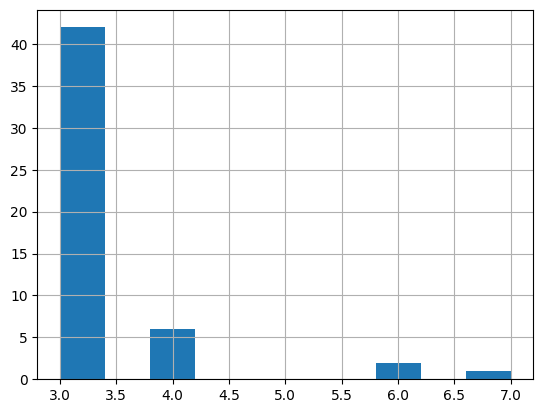

#### 2.3 DIA data

Last, we have the raw DIA data objecrt loaded from the Thermo raw file.

This object contains all scans in the `dia_data.spectrum_df` DataFrame.
Each spectrum points to a collection of peak based on the `peak_start_idx` and `peak_stop_idx` columns.

These point to the `dia_data.peak_df` DataFrame, which contains the peak information.

In [10]:
dia_data.spectrum_df.head()

,spec_idx,peak_start_idx,peak_stop_idx,rt,precursor_mz,precursor_charge,isolation_lower_mz,isolation_upper_mz,ms_level,nce
0,0,0,35,0.000000,-1.00000,0,-1.000000,-1.000000,1,0.0
1,1,35,42,0.000439,385.42508,0,384.424625,386.425535,2,25.0
2,2,42,43,0.000521,389.42691,0,388.426455,390.427365,2,25.0
3,3,43,44,0.000601,395.42963,0,394.429175,396.430085,2,25.0
4,4,44,45,0.000694,397.43054,0,396.430085,398.430995,2,25.0


In [11]:
dia_data.peak_df.head()

,mz,intensity
0,459.638519,13105.375977
1,470.064972,10583.207031
2,472.338043,10462.697266
3,479.018433,10998.292969
4,507.042847,13371.034180


#### 3 Map precursor hit from search results to raw data

Using this information we can map the identified precursors to the raw data.

We will use the `get_library_entry_by_hash` function to get the library entry for a given hash.

This function returns the library entry, the fragment m/z values and the fragment intensities.



In [52]:
def get_library_entry_by_hash(speclib, hash, min_intensity=0.01):
    speclib_entry = speclib.precursor_df[speclib.precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

    fragment_mz = speclib.fragment_mz_df.iloc[speclib_entry.frag_start_idx:speclib_entry.frag_stop_idx].to_numpy().flatten()
    fragment_intensity = speclib.fragment_intensity_df.iloc[speclib_entry.frag_start_idx:speclib_entry.frag_stop_idx].to_numpy().flatten()
    fragment_mask = fragment_intensity > min_intensity

    fragment_mz = fragment_mz[fragment_mask]
    fragment_intensity = fragment_intensity[fragment_mask]

    # sort both by mz
    fragment_order = np.argsort(fragment_mz)
    fragment_mz = fragment_mz[fragment_order]
    fragment_intensity = fragment_intensity[fragment_order]

    return speclib_entry, fragment_mz, fragment_intensity

def get_flat_library_entry_by_hash(speclib_flat, hash, min_intensity=0.01):
    speclib_entry = speclib_flat.precursor_df[speclib_flat.precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

    flat_frag_start_idx = speclib_entry.flat_frag_start_idx
    flat_frag_stop_idx = speclib_entry.flat_frag_stop_idx

    fragment_mz = speclib_flat.fragment_df['mz'].iloc[flat_frag_start_idx:flat_frag_stop_idx].to_numpy().flatten()
    fragment_intensity = speclib_flat.fragment_df['intensity'].iloc[flat_frag_start_idx:flat_frag_stop_idx].to_numpy().flatten()
    fragment_mask = fragment_intensity > min_intensity

    fragment_mz = fragment_mz[fragment_mask]
    fragment_intensity = fragment_intensity[fragment_mask]

    # sort both by mz
    fragment_order = np.argsort(fragment_mz)
    fragment_mz = fragment_mz[fragment_order]
    fragment_intensity = fragment_intensity[fragment_order]

    return speclib_entry, fragment_mz, fragment_intensity

jit_data = dia_data.jitclass()

In [88]:
hash = precursor_df['mod_seq_charge_hash'].iloc[44997]

speclib_entry, mz_library, intensity_library = get_flat_library_entry_by_hash(spectral_library_flat, hash)

precursor_entry = precursor_df[precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

precursor_query = np.array([[speclib_entry.precursor_mz, speclib_entry.precursor_mz]], dtype=np.float32)
scan_limits = np.array([[precursor_entry.scan_start, precursor_entry.scan_stop, 1]], dtype=np.int64)
frame_limits = np.array([[precursor_entry.frame_start, precursor_entry.frame_stop, 1]], dtype=np.int64)

dense, precursor_index = jit_data.get_dense(
    frame_limits,
    scan_limits,
    mz_library,
    30,
    precursor_query,
)

#### 4 Visualize precursor data

Now, we want to viosualize the retrieved spectrum data.
We will start by visualizing the observed spectrum and the library spectrum.

The spectrum data `dense` is a 5 dimensional numpy array with a dense slice of the spectrum space.
The dimensions are:
- 0: either intensity information 0 or relative mass error 1
- 1: index of the fragment mz which was queried
- 2: ion mobility dimension (will be zero for DIA data)
- 3: The observations in the DIA cycle. As there might be multiple quadrupole windows where the precursor was detected, this will be a list of observations.
- 4: Retention time datapoints.

First we will select the intensity dimension and sum over all other dimensions but the fragment mz dimension.


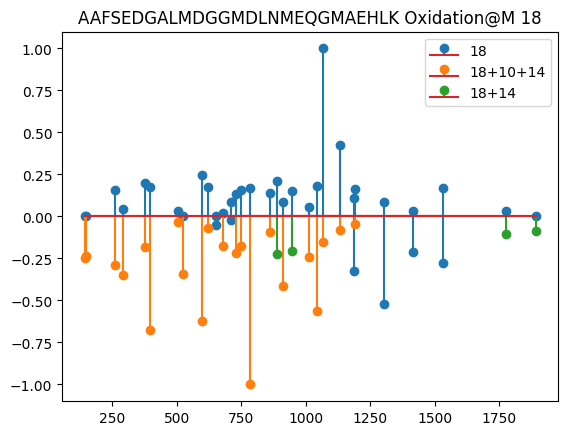

In [167]:
hash = precursor_df['mod_seq_charge_hash'].loc[44997]

speclib_entry, mz_library, intensity_library = get_flat_library_entry_by_hash(spectral_library_flat, hash)

precursor_entry = precursor_df[precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

precursor_query = np.array([[speclib_entry.precursor_mz, speclib_entry.precursor_mz]], dtype=np.float32)
scan_limits = np.array([[precursor_entry.scan_start, precursor_entry.scan_stop, 1]], dtype=np.int64)
frame_limits = np.array([[precursor_entry.frame_start, precursor_entry.frame_stop, 1]], dtype=np.int64)

dense, precursor_index = jit_data.get_dense(
    frame_limits,
    scan_limits,
    mz_library,
    30,
    precursor_query,
)


library_isoforms = spectral_library_flat.precursor_df.loc[np.logical_and(spectral_library_flat.precursor_df['sequence'] == precursor_entry['sequence'],
               spectral_library_flat.precursor_df['mods'] == precursor_entry['mods']), :]

fragment_tables = []
for i, e in library_isoforms.iterrows():
    t = spectral_library_flat.fragment_df[e['flat_frag_start_idx']:e['flat_frag_stop_idx']]
    t['isoform'] = e['mod_sites']
    fragment_tables.append(t)

spec = pd.concat(fragment_tables).groupby('mz').agg({'isoform': lambda s: '+'.join(s)})
spec['discrimination'] = 1 - (spec['isoform'].str.count('\+')) / library_isoforms.shape[0]

library_spec = pd.DataFrame({'mz': mz_library, 'intensity': intensity_library})
library_spec['isoform'] = list(spec.reindex(library_spec['mz'])['isoform'])


intensity_observed = dense[0].sum(axis=(1,2,3))
intensity_observed_normalized = intensity_observed / intensity_observed.max()
library_spec['intensity'] = library_spec['intensity'] / library_spec['intensity'].max()

plt.stem(mz_library, intensity_observed_normalized)
for n, (iii, gr) in enumerate(library_spec.groupby('isoform')):
    plt.stem(gr['mz'], -1 * gr['intensity'], linefmt=plt.colormaps['tab10'](n), label=iii)

plt.legend()
plt.title('{} {} {}'.format(precursor_entry['sequence'], precursor_entry['mods'], precursor_entry['mod_sites']))
plt.show()

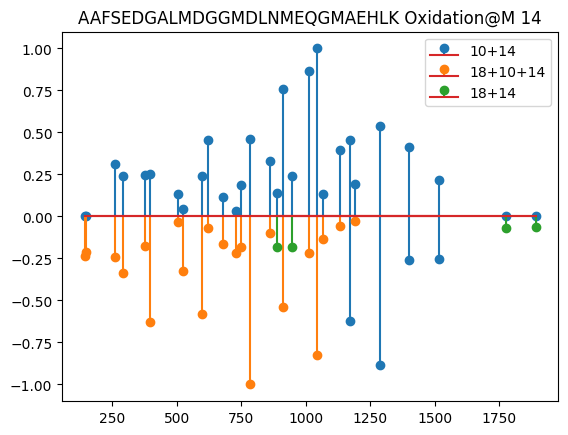

In [169]:
hash = precursor_df['mod_seq_charge_hash'].loc[45127]

speclib_entry, mz_library, intensity_library = get_flat_library_entry_by_hash(spectral_library_flat, hash)

precursor_entry = precursor_df[precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

precursor_query = np.array([[speclib_entry.precursor_mz, speclib_entry.precursor_mz]], dtype=np.float32)
scan_limits = np.array([[precursor_entry.scan_start, precursor_entry.scan_stop, 1]], dtype=np.int64)
frame_limits = np.array([[precursor_entry.frame_start, precursor_entry.frame_stop, 1]], dtype=np.int64)

dense, precursor_index = jit_data.get_dense(
    frame_limits,
    scan_limits,
    mz_library,
    30,
    precursor_query,
)

library_isoforms = spectral_library_flat.precursor_df.loc[np.logical_and(spectral_library_flat.precursor_df['sequence'] == precursor_entry['sequence'],
               spectral_library_flat.precursor_df['mods'] == precursor_entry['mods']), :]

fragment_tables = []
for i, e in library_isoforms.iterrows():
    t = spectral_library_flat.fragment_df[e['flat_frag_start_idx']:e['flat_frag_stop_idx']]
    t['isoform'] = e['mod_sites']
    fragment_tables.append(t)

spec = pd.concat(fragment_tables).groupby('mz').agg({'isoform': lambda s: '+'.join(s)})
spec['discrimination'] = 1 - (spec['isoform'].str.count('\+')) / library_isoforms.shape[0]

library_spec = pd.DataFrame({'mz': mz_library, 'intensity': intensity_library})
library_spec['isoform'] = list(spec.reindex(library_spec['mz'])['isoform'])


intensity_observed = dense[0].sum(axis=(1,2,3))
intensity_observed_normalized = intensity_observed / intensity_observed.max()
library_spec['intensity'] = library_spec['intensity'] / library_spec['intensity'].max()

plt.stem(mz_library, intensity_observed_normalized)
for n, (iii, gr) in enumerate(library_spec.groupby('isoform')):
    plt.stem(gr['mz'], -1 * gr['intensity'], linefmt=plt.colormaps['tab10'](n), label=iii)

plt.legend()
plt.title('{} {} {}'.format(precursor_entry['sequence'], precursor_entry['mods'], precursor_entry['mod_sites']))
plt.show()

Finally, we will visualize the Precusor ion chromatogram.
We will again select the intensity dimension and sum over ion mobility and observation but leave the retention time dimension.


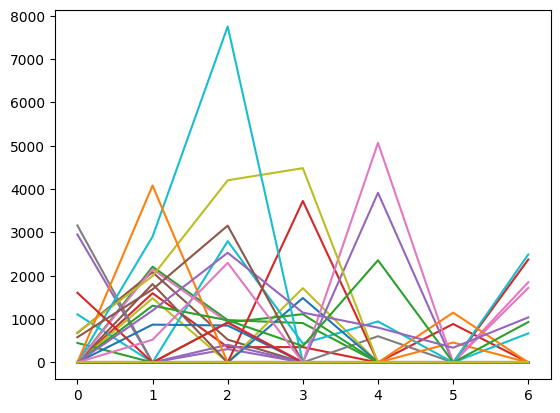

In [102]:
xic_observed = dense[0].sum(axis=(1,2))
for i in range(xic_observed.shape[0]):
    plt.plot(xic_observed[i])
plt.show()

In [163]:
library_spec['isoform'] = list(spec.reindex(library_spec['mz'])['isoform'])
library_spec

,mz,intensity,isoform
0,143.081497,0.232587,18+10+14
1,147.112808,0.210039,18+10+14
2,260.196869,0.241341,18+10+14
3,290.149933,0.338522,18+10+14
4,377.181946,0.176099,18+10+14
5,397.255768,0.629898,18+10+14
6,506.224548,0.031906,18+10+14
7,526.298401,0.325312,18+10+14
8,597.335510,0.582238,18+10+14
9,621.251465,0.067734,18+10+14


In [72]:
isoforms = precursor_df.groupby(['sequence', 'mods', 'charge']).filter(lambda g: g['mod_sites'].unique().shape[0] == 2).sort_values('sequence').iloc[:2]

In [87]:
isoforms['mod_seq_charge_hash']

44997     1993543853944557267
45127    13563512112259994275
Name: mod_seq_charge_hash, dtype: uint64

In [104]:
library_isoforms = spectral_library_flat.precursor_df.loc[np.logical_and(spectral_library_flat.precursor_df['sequence'] == isoforms['sequence'].iloc[0],
               spectral_library_flat.precursor_df['mods'] == isoforms['mods'].iloc[0]), :]

In [106]:
library_isoforms[['sequence', 'mods', 'charge', 'mod_sites', 'flat_frag_start_idx', 'flat_frag_stop_idx']]

,sequence,mods,charge,mod_sites,flat_frag_start_idx,flat_frag_stop_idx
248256,AAFSEDGALMDGGMDLNMEQGMAEHLK,Oxidation@M,3,18,5212488,5212520
248436,AAFSEDGALMDGGMDLNMEQGMAEHLK,Oxidation@M,3,10,5218439,5218470
249247,AAFSEDGALMDGGMDLNMEQGMAEHLK,Oxidation@M,3,14,5245058,5245087


In [119]:
fragment_tables = []
for o, (i, e) in enumerate(library_isoforms.iterrows()):
    t = spectral_library_flat.fragment_df[e['flat_frag_start_idx']:e['flat_frag_stop_idx']]
    t['isoform'] = 10**o 
    fragment_tables.append(t)

In [120]:
fragment_tables

[                  mz  intensity  type  loss_type  charge  number  position  \
 5212488   143.081497   0.249360    98          0       1       2         1   
 5212489   290.149933   0.349920    98          0       1       3         2   
 5212490  1298.045166   0.008059   121          0       2      24         2   
 5212491   377.181946   0.182014    98          0       1       4         3   
 5212492   506.224548   0.034355    98          0       1       5         4   
 5212493  1190.007812   0.042942   121          0       2      22         4   
 5212494   621.251465   0.068847    98          0       1       6         5   
 5212495  1132.494385   0.078915   121          0       2      21         5   
 5212496   678.272949   0.173613    98          0       1       7         6   
 5212497   749.310059   0.177052    98          0       1       8         7   
 5212498  1068.465088   0.150220   121          0       2      19         7   
 5212499   862.394104   0.092489    98          0   

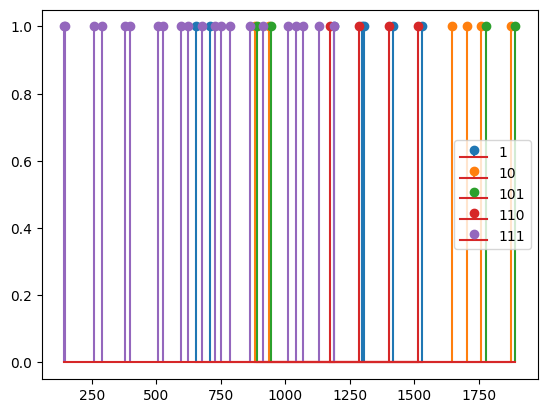

In [137]:
spec = pd.concat(fragment_tables).groupby('mz').agg({'isoform': 'sum'}).reset_index()

for n, (iii, gr) in enumerate(spec.groupby('isoform')):
    plt.stem(gr['mz'], np.ones(gr.shape[0]), linefmt=plt.colormaps['tab10'](n), label=iii)

plt.legend()
#for spec in fragment_tables:
#    plt.stem(spec['mz'], spec['intensity'])

In [135]:
plt.colormaps['tab10'](1)

(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)